In [2]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import train_test_split

from generate_design_matrix import ExpFilter
from get_rat_data import *
from multiclass_logistic_regression import MultiClassLogisticRegression
from sigma_feature_search_experiment_feature_comparison import DesignMatrixGeneratorFeatureComparison # SigmaTauSearchExperimentFeatureComparison
from method_validation import plot_kernel_validation

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

In [127]:
df = get_rat_viol_data("W065")

returning data for W065


In [166]:
class SigmaFeatureSearchExperimentFeatureComparison:
    def __init__(self, params):
        self.animals = params["animals"]
        self.sigmas = params["sigmas"]
        self.model_names = params["model_names"]
        self.random_state = params["random_state"]
        self.test_size = params["test_size"]
        self.df = get_rat_viol_data(animal_ids=self.animals)
        self.stored_fits = []

        if self.animals is None:
            self.animals = self.df.animal_id.unique()

        self.n_animals = len(self.animals)

    def run(self):
        for animal in self.animals:
            print(f"\n\n !!!!! evaluating animal {animal} !!!!!\n\n")
            if self.df.animal_id.nunique() > 1:
                # Load in data for specific animal
                animal_df = self.df.query("animal_id == @animal and training_stage > 2")
            else:
                animal_df = self.df.query("training_stage > 2")

            # Create a DesignMatrixGenerator object & get train/test sessions for animal
            dmg = DesignMatrixGeneratorFeatureComparison(verbose=False)
            dmg.get_train_test_sessions(
                animal_df, test_size=self.test_size, random_state=self.random_state
            )

            # Iterate over sigma/model combinations
            for sigma in self.sigmas:
                for idx, model_name in enumerate(self.model_names):
                    print(f"\nsigma: {sigma}, model_name: {model_name}\n")
                    # Generate design matrix & create train/test splits
                    X, Y = dmg.generate_design_matrix(
                        animal_df,
                        feature_mode=model_name,
                        return_labels=True,
                    )
                    (
                        X_train,
                        X_test,
                        Y_train,
                        Y_test,
                    ) = dmg.apply_session_train_test_split(X, Y)

                    # Fit model & evaluate
                    model = MultiClassLogisticRegression(sigma=sigma)
                    W_fit = model.fit(X_train, Y_train)
                    nll = model.eval(X_test, Y_test)

                    # Store results
                    self.store(animal, model_name, nll, sigma, X_test, W_fit)

        self.results = pd.concat(self.stored_fits, ignore_index=True)
        return self.results

    def store(self, animal, model_name, nll, sigma, X, W_fit):
        # Create a DataFrame for this iteration
        iter_df = pd.DataFrame(
            {
                "animal_id": [animal],
                "model_name": [model_name],
                "nll": [nll],
                "sigma": [sigma],
                "features": [list(X.columns)],
                "weights": [list(W_fit)],  # Convert numpy array to list
            }
        )
        # Append to the list of stored fits
        self.stored_fits.append(iter_df)

        ## WRANGLING ##

    def find_best_fit(self, group="model_name"):
        # if group is model_name, will find the best sigma for
        # each model tested.
        # if group is sigma, will find the best model for
        # each sigma tested.

        best_fit_dfs = []

        for animal_id, sub_df in self.results.groupby(["animal_id"]):
            best_idx = sub_df.groupby(group)["nll"].idxmin()
            best_fit_df = sub_df.loc[best_idx][
                ["animal_id", "model_name", "sigma", "nll"]
            ]
            best_fit_dfs.append(best_fit_df)

        return pd.concat(best_fit_dfs, ignore_index=True)

    def query_min_nll(self, animal_id, model_name):
        """
        Query the row with the minimum NLL for a given animal_id and model_name
        """
        query = self.results.query(
            "animal_id == @animal_id and model_name == @model_name"
        ).sort_values(by="nll", ascending=True)

        return query.iloc[0]

    ## PLOTTING ##

    def plot_nll_over_sigmas(self, df=None):  # self
        if df is None:
            df = self.find_best_fit(group="sigma")

        n_animals = df.animal_id.nunique()
        fig, ax = plt.subplots(
            n_animals, 1, figsize=(15, 5 * n_animals), sharex=True, sharey=False
        )

        df["is_min"] = df.groupby("animal_id")["nll"].transform(lambda x: x == x.min())

        if n_animals == 1:
            ax = [ax]

        for idx, (animal_id, sub_df) in enumerate(df.groupby("animal_id")):
            plt.xticks(rotation=90)

            current_ax = ax[idx] if n_animals > 1 else ax[0]

            sns.scatterplot(
                x="sigma",
                y="nll",
                data=sub_df,
                ax=current_ax,
                hue="is_min",
                palette=["grey", "red"],
            )

            # aesthetics
            plt.xticks(rotation=90)
            sns.despine()
            current_ax.legend().remove()
            current_ax.set(
                ylabel="Test NLL",
                title=f"Animal {animal_id}",
            )
            # if on the last plot, add the x-axis label
            if idx == n_animals - 1:
                current_ax.set(xlabel="Sigma")
            else:
                current_ax.set(xlabel="")

        return None

    def plot_class_weights(self, animal_id, model_name, ax=None):
        """
        Wrapper function to plot class weights for a given animal and model
        """
        row = self.query_min_nll(animal_id, model_name)
        self._plot_class_weights(
            row["features"],
            np.array(row["weights"]),
            title=f"{animal_id} {model_name}",
            ax=ax,
        )

    def _plot_class_weights(self, feature_names, W_fit, title="", ax=None):
        """
        Internal function to plot the weights for each feature and class as bar charts.
        """
        D, C = W_fit.shape
        classes = ["L", "R", "V"]

        weight_data = [
            {"Weight": W_fit[d, c], "Feature": feature_names[d], "Class": classes[c]}
            for c in range(C)
            for d in range(D)
        ]
        df_weights = pd.DataFrame(weight_data)

        if not ax:
            fig, ax = plt.subplots(figsize=(15, 6))
        ax.axhline(y=0, color="black")
        sns.barplot(x="Feature", y="Weight", hue="Class", data=df_weights, ax=ax)
        plt.xticks(rotation=45)
        plt.legend(loc="upper left")
        plt.title(title)

In [3]:
df = get_rat_viol_data("W065")

if df.animal_id.nunique() > 1:
    # Load in data for specific animal
    animal_df = df.query("animal_id == @animal and training_stage > 2")
else:
    animal_df = df.query("training_stage > 2")

# Create a DesignMatrixGenerator object & get train/test sessions for animal
dmg = DesignMatrixGeneratorFeatureComparison(verbose=False)
dmg.get_train_test_sessions(animal_df, test_size=0.25, random_state=44)

X, Y = dmg.generate_design_matrix(
    animal_df,
    feature_mode="psytrack",
    return_labels=True,
)
(
    X_train,
    X_test,
    Y_train,
    Y_test,
) = dmg.apply_session_train_test_split(X, Y)

returning data for W065


In [10]:
len(dmg.test_sessions)

42

In [7]:
len(dmg.fit_null_model(animal_df))

10098

In [167]:
params = {
    "animals": None,
    "sigmas": [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 3, 5],
    "model_names": [
        "psytrack",
        "prev_violation",
        "prev_violation_filter",
        "prev_reward",
        "prev_reward_filter",
        "prev_reward_inc_delay",
    ],
    "random_state": 60,
    "test_size": 0.25,
}

experiment = SigmaFeatureSearchExperimentFeatureComparison(params)

returning dataset for all animals


In [168]:
results = experiment.run()



 !!!!! evaluating animal W051 !!!!!



sigma: 0, model_name: psytrack

         Current function value: 558807.482837
         Iterations: 22
         Function evaluations: 34
         Gradient evaluations: 34

sigma: 0, model_name: prev_violation

         Current function value: 519251.003073
         Iterations: 24
         Function evaluations: 35
         Gradient evaluations: 35

sigma: 0, model_name: prev_violation_filter

         Current function value: 489373.522901
         Iterations: 24
         Function evaluations: 35
         Gradient evaluations: 35

sigma: 0, model_name: prev_reward

         Current function value: 488307.977655
         Iterations: 24
         Function evaluations: 92
         Gradient evaluations: 80

sigma: 0, model_name: prev_reward_filter

         Current function value: 488125.086481
         Iterations: 25
         Function evaluations: 36
         Gradient evaluations: 36

sigma: 0, model_name: prev_reward_inc_delay

         Current funct

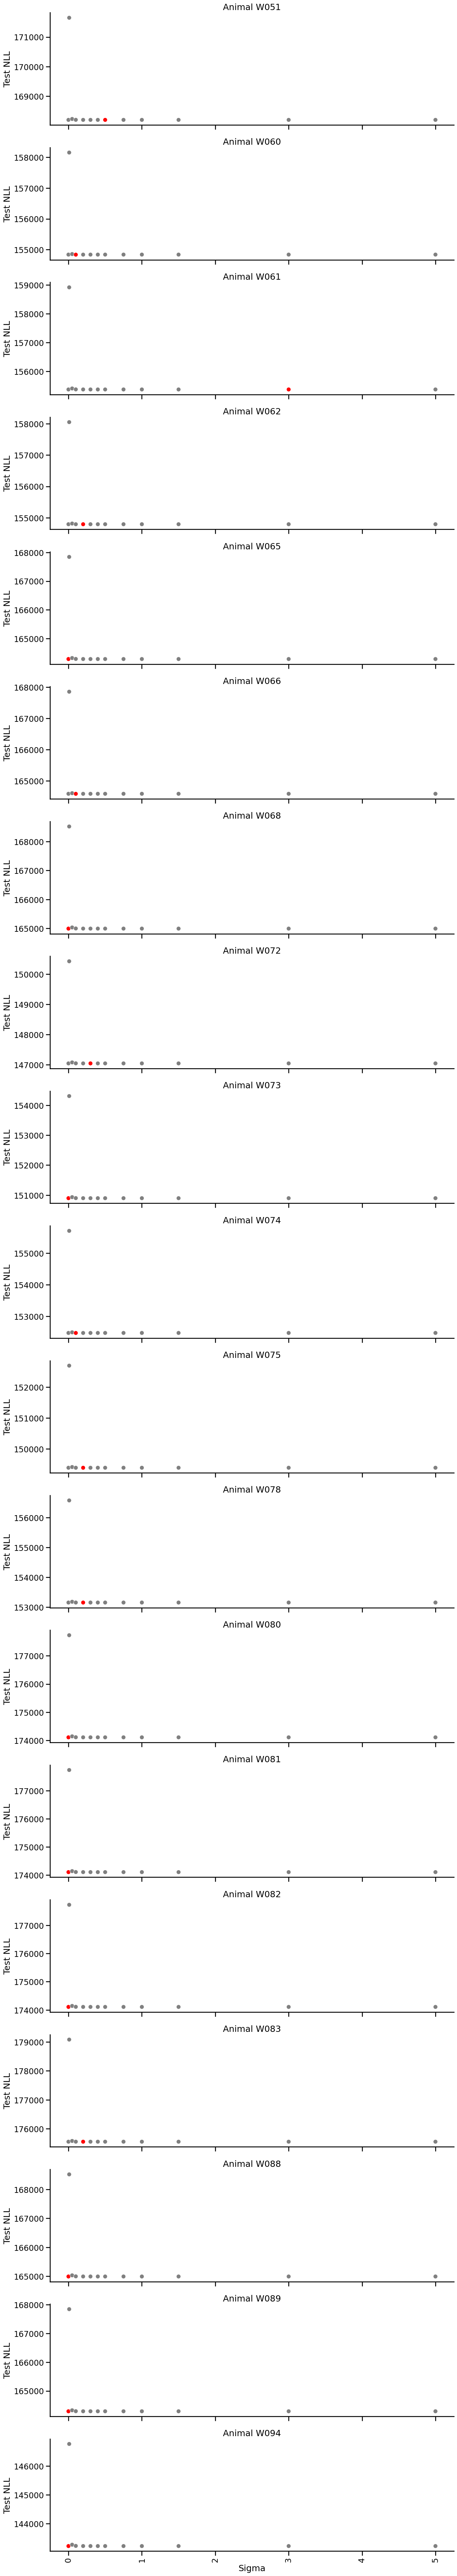

In [169]:
experiment.plot_nll_over_sigmas()

In [170]:
def plot_nll_over_models_by_animal(experiment, df=None):
    if df is None:
        df = experiment.find_best_fit(group="model_name")

    fig, ax = plt.subplots(
        experiment.n_animals,
        1,
        figsize=(8, 5 * experiment.n_animals),
        sharex=True,
        sharey=False,
    )

    df["is_min"] = df.groupby("animal_id")["nll"].transform(lambda x: x == x.min())

    if experiment.n_animals == 1:
        ax = [ax]

    for idx, (animal_id, sub_df) in enumerate(df.groupby("animal_id")):
        current_ax = ax[idx] if experiment.n_animals > 1 else ax[0]

        sns.pointplot(
            x="model_name",
            y="nll",
            data=sub_df,
            ax=current_ax,
            order=experiment.model_names,
            hue="is_min",
            palette=["grey", "red"],
            join=False,
        )

        # aesthetics
        plt.xticks(rotation=90)
        sns.despine()
        current_ax.legend().remove()
        current_ax.set(
            ylabel="Test NLL",
            title=f"Animal {animal_id}",
        )

        # if on the last plot, add the x-axis label
        if idx == experiment.n_animals - 1:
            current_ax.set(xlabel="Model Name")
        else:
            current_ax.set(xlabel="")

    return None

In [171]:
def plot_nll_over_models(experiment, hue="animal_id", df=None):
    if df is None:
        df = experiment.find_best_fit(group="model_name")

    fig, ax = plt.subplots(figsize=(8, 5))

    sns.pointplot(
        x="model_name",
        y="nll",
        data=df,
        ax=ax,
        order=experiment.model_names,
        hue=hue,
        join=True,
    )

    # aesthetics
    plt.xticks(rotation=90)
    sns.despine()
    if hue:
        ax.legend().remove()
    ax.set(ylabel="Test NLL", title=f"NLL Over Animals", xlabel="Model Name")

    return None

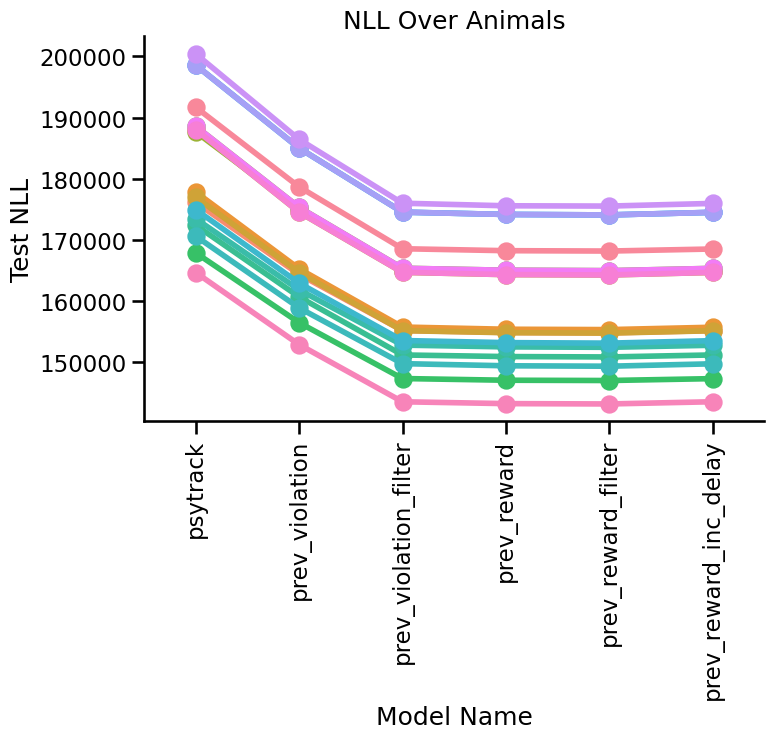

In [172]:
plot_nll_over_models(experiment, hue="animal_id")

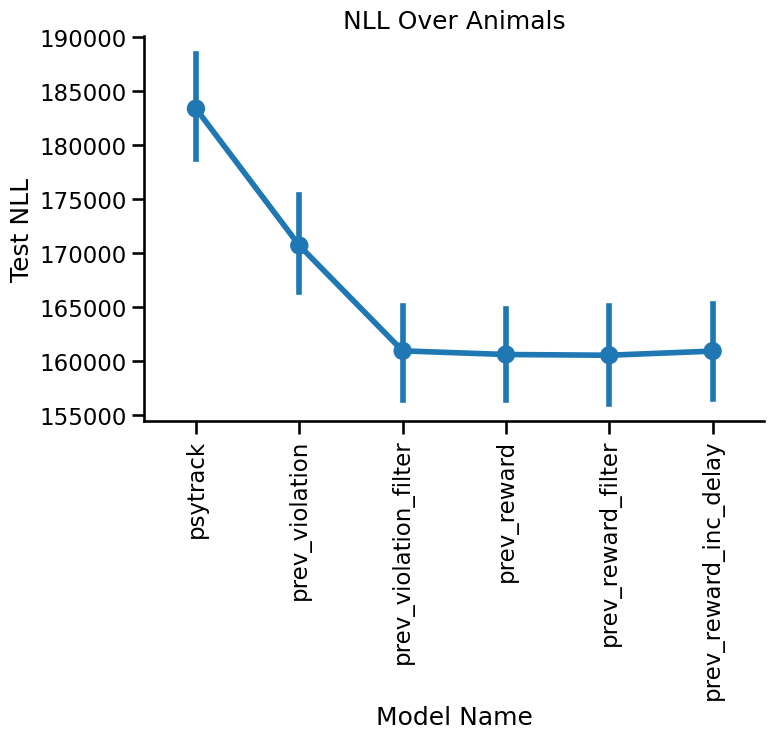

In [173]:
plot_nll_over_models(experiment, hue=None)

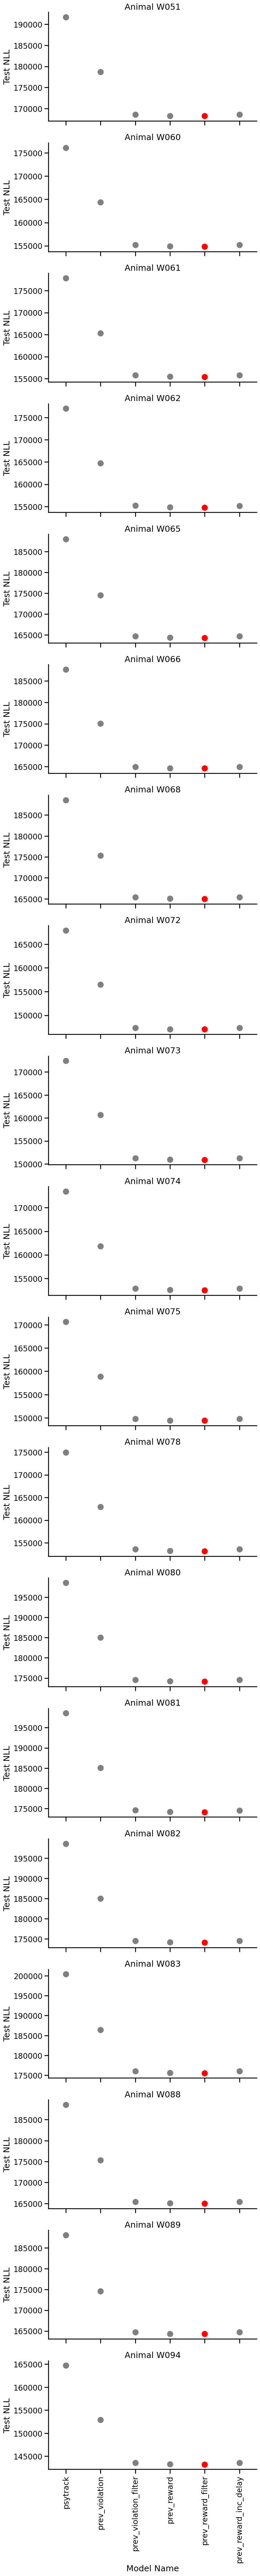

In [174]:
plot_nll_over_models_by_animal(experiment)

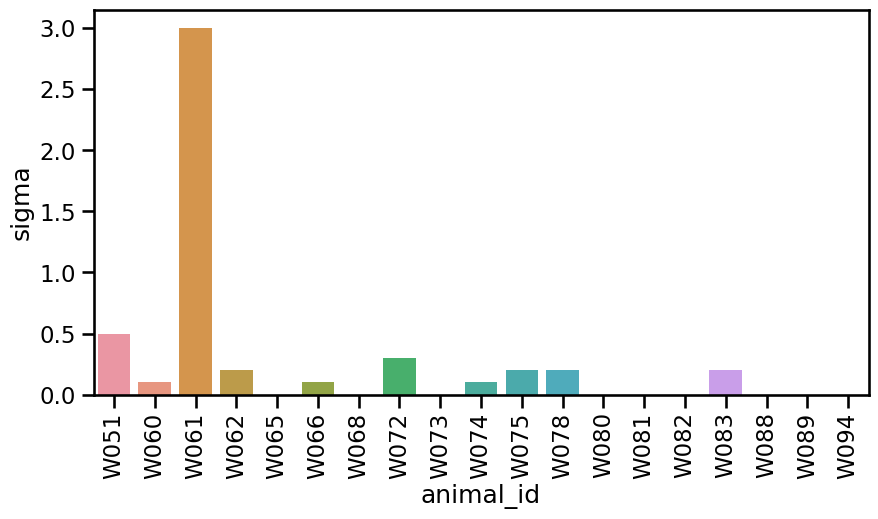

In [175]:
fig, ax = plt.subplots(figsize=(10, 5))
sum_df = experiment.find_best_fit(group=["animal_id"])

sns.barplot(data=sum_df, x="animal_id", y="sigma", ax=ax)
_ = plt.xticks(rotation=90)

In [176]:
results.to_csv("feature_comparison_stg3_dropped.csv", index=False)